# Audio UX

Task mAIstro supports voice interactions using:
- [OpenAI's Whisper](https://platform.openai.com/docs/guides/speech-to-text) for speech-to-text
- [ElevenLabs](https://github.com/elevenlabs/elevenlabs-python) for text-to-speech

### Install dependencies

Ensure you have `ffmpeg` installed for using ElevenLabs. 

On MacOS, you can install it with `brew install ffmpeg`. 

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph langchain_core sounddevice scipy elevenlabs langgraph-prebuilt 

### Set environment variables

* Set your `OPENAI_API_KEY`
* Set your `ELEVENLABS_API_KEY` (available [here](https://elevenlabs.io/api))
* Optional: Set your `LANGCHAIN_API_KEY` (available [here](https://smith.langchain.com/)) if you want tracing or want to connect with a hosted deployment.

In [ ]:
import os
os.environ["ELEVENLABS_API_KEY"] = ""
os.environ["LANGCHAIN_API_KEY"]=""
os.environ["OPENAI_API_KEY"]=""

In [3]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
_set_env("ELEVENLABS_API_KEY")
_set_env("OPENAI_API_KEY")

import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "voice-agent-deployment"

### Connect to your deployment

Connect to your deployment using the URL endpoint:
- **Studio**: Found in Studio UI 
- **CLI**: Printed to console (typically `http://localhost:8123`)
- **Cloud**: Available in LangGraph Deployment page

We'll connect to the deployment as a [RemoteGraph](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#how-to-interact-with-the-deployment-using-remotegraph). 


In [4]:
from langgraph.pregel.remote import RemoteGraph
from langchain_core.messages import convert_to_messages
from langchain_core.messages import HumanMessage, SystemMessage

# Local deployment (via LangGraph Studio)
local_deployment_url = "http://localhost:2024"

# Deployment URL
cloud_deployment_url = "https://task-maistro-1b681add7a2b549499bb0cd21a7e5be4.default.us.langgraph.app"

# Graph name
graph_name = "agent" 

# Connect to the deployment
remote_graph = RemoteGraph(graph_name, url=local_deployment_url)

You can test your deployment by running the following. 

In [22]:
# Int
user_input = "Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old."
config = {"configurable": {"user_id": "Test-Deployment-User"}}
for chunk in remote_graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="values", config=config):
    convert_to_messages(chunk["messages"])[-1].pretty_print()

================================ Human Message =================================

Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old.
================================= Tool Message =================================
Name: transfer_to_memory_agent

Successfully transferred to memory_agent
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
================================== Ai Message ==================================
Name: supervisor

Hi Lance! How can I assist you today?


### Add audio

Our deployed graph has some benefits: 
* It has built-in support for long-term memory 
* It implements all the logic for task mAIstro 

But, we have a challenge:
* It takes test as input and returns text as output

We need to add audio input and output to the graph. So, we'll simply add two nodes to our graph:

1. **Audio Input Node**
   * Records microphone input (stop with Enter)
   * Transcribes speech using Whisper
   * Passes text to Task mAIstro

2. **Audio Output Node**
   * Takes Task mAIstro's text response
   * Converts to speech via ElevenLabs
   * Plays audio response

We can achieve this by embedding our deployed graph [as a node](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#using-as-a-subgraph) in a new graph. 

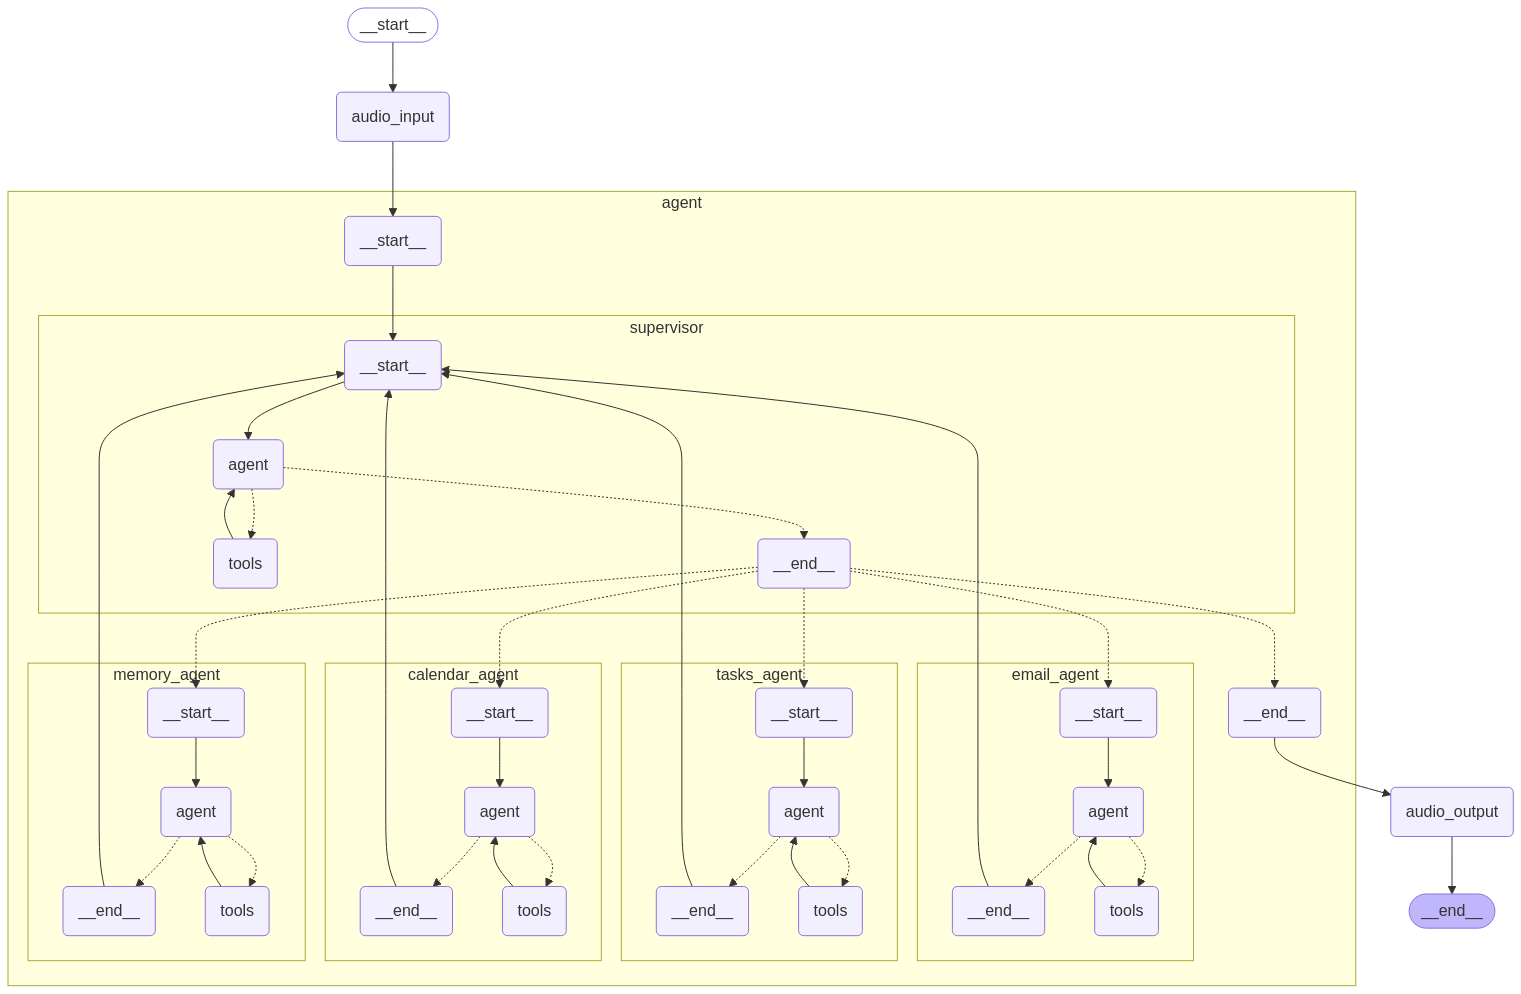

In [5]:
import io
import threading
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write
from IPython.display import Image, display

from openai import OpenAI

from elevenlabs import play, VoiceSettings
from elevenlabs.client import ElevenLabs

from langgraph.graph import StateGraph, MessagesState, END, START

# Initialize OpenAI client
openai_client = OpenAI()

# Initialize ElevenLabs client
elevenlabs_client = ElevenLabs(api_key=os.getenv("ELEVENLABS_API_KEY"))

def record_audio_until_stop(state: MessagesState):

    """Records audio from the microphone until Enter is pressed, then saves it to a .wav file."""
    
    audio_data = []  # List to store audio chunks
    recording = True  # Flag to control recording
    sample_rate = 16000 # (kHz) Adequate for human voice frequency

    def record_audio():
        """Continuously records audio until the recording flag is set to False."""
        nonlocal audio_data, recording
        with sd.InputStream(samplerate=sample_rate, channels=1, dtype='int16') as stream:
            print("Recording your instruction! ... Press Enter to stop recording.")
            while recording:
                audio_chunk, _ = stream.read(1024)  # Read audio data in chunks
                audio_data.append(audio_chunk)

    def stop_recording():
        """Waits for user input to stop the recording."""
        input()  # Wait for Enter key press
        nonlocal recording
        recording = False

    # Start recording in a separate thread
    recording_thread = threading.Thread(target=record_audio)
    recording_thread.start()

    # Start a thread to listen for the Enter key
    stop_thread = threading.Thread(target=stop_recording)
    stop_thread.start()

    # Wait for both threads to complete
    stop_thread.join()
    recording_thread.join()

    # Stack all audio chunks into a single NumPy array and write to file
    audio_data = np.concatenate(audio_data, axis=0)
    
    # Convert to WAV format in-memory
    audio_bytes = io.BytesIO()
    write(audio_bytes, sample_rate, audio_data)  # Use scipy's write function to save to BytesIO
    audio_bytes.seek(0)  # Go to the start of the BytesIO buffer
    audio_bytes.name = "audio.wav" # Set a filename for the in-memory file

    # Transcribe via Whisper
    transcription = openai_client.audio.transcriptions.create(
       model="whisper-1", 
       file=audio_bytes,
    )

    # Print the transcription
    print("Here is the transcription:", transcription.text)

    # Write to messages 
    return {"messages": [HumanMessage(content=transcription.text)]}

import re
import html

def clean_text(text):
    # Decode any HTML entities (if present)
    text = html.unescape(text)
    
    # Remove Markdown emphasis (e.g., **text**, *text*, __text__, _text_)
    text = re.sub(r'(\*\*|\*|__|_)', '', text)
    
    # Remove URLs that start with http://, https://, or www.
    text = re.sub(r'(https?://\S+)|(www\.\S+)', '', text)
    
    # Remove any HTML-like tags or bracketed content which might not be pronounceable
    text = re.sub(r'<.*?>', '', text)
    
    # Remove other extraneous characters that might affect TTS quality.
    # Here you can add or adjust characters/patterns as needed.
    # For example, remove hash symbols, at symbols, or angle brackets.
    text = re.sub(r'[#@<>]', '', text)
    
      # Remove triple backticks used often to denote code blocks
    text = re.sub(r'```', '', text)
    
    # Remove sequences of four or more periods (e.g., "....")
    text = re.sub(r'\.{3,}', '', text)

    # Normalize spaces: replace multiple spaces/newlines with a single space
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def play_audio(state: MessagesState):
    
    """Plays the audio response from the remote graph with ElevenLabs."""

    # Response from the agent 
    response = state['messages'][-1]

    # Prepare text by replacing ** with empty strings
    # These can cause unexpected behavior in ElevenLabs
    cleaned_text = clean_text(response.content)
    
    # Call text_to_speech API with turbo model for low latency
    response = elevenlabs_client.text_to_speech.convert(
        voice_id="pNInz6obpgDQGcFmaJgB",
        output_format="mp3_22050_32",
        text=cleaned_text,
        model_id="eleven_turbo_v2_5", 
        voice_settings=VoiceSettings(
            stability=0.0,
            similarity_boost=1.0,
            style=0.0,
            use_speaker_boost=True,
        ),
    )
    
    # Play the audio back
    play(response)

# Define parent graph
builder = StateGraph(MessagesState)

# Add remote graph directly as a node
builder.add_node("audio_input", record_audio_until_stop)
builder.add_node("agent", remote_graph)
builder.add_node("audio_output", play_audio)
builder.add_edge(START, "audio_input")
builder.add_edge("audio_input", "agent")
builder.add_edge("agent","audio_output")
builder.add_edge("audio_output",END)
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Optionally, you can supply a thread ID to ensure that conversation history is persisted. 

In [7]:
import uuid
thread_id = str(uuid.uuid4())
thread_id

'214ddd3b-89f6-4de2-a5d3-fee12792a57b'

Simply, run this cell and speak into your microphone. When you are finished, press Enter.

In [10]:
# Set user ID for storing memories
config = {"configurable": {"user_id": "Test-Audio-UX", "thread_id": thread_id}}

# Kick off the graph, which will record user input until the user presses Enter
for chunk in graph.stream({"messages":HumanMessage(content="Follow the user's instructions:")}, stream_mode="values", config=config):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Follow the user's instructions:
Recording your instruction! ... Press Enter to stop recording.
Here is the transcription: Can you tell me my name?
================================ Human Message =================================

Can you tell me my name?
================================== Ai Message ==================================
Name: supervisor

Your name is Shreyas. How can I assist you further today?


In [ ]:
from langgraph_supervisor import create_supervisor
create_supervisor

In [ ]:
from langmem import create_manage_memory_tool, create_search_memory_tool

manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "quick_task_assistant", 
        "{user_id}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "quick_task_assistant",
        "{user_id}",
        "collection"
    )
)